In [1]:
import sys, os
sys.path.append('.')

import pandas as pd 
import numpy as np 
import anndata
import scanpy as sc

import scipy.sparse as sp
from scipy.io import mmread
from scipy.sparse import load_npz, save_npz, csr_matrix

from umap import UMAP
from sklearn.decomposition import PCA

import utils

## Read in count data

In [3]:
path = "./raw/"

# load compressed data for scRNA-Seq
barcodes_rna = pd.read_csv(path + "barcodes_rna.txt", header = None).values.squeeze()
genes = pd.read_csv(path + "genes.txt", header = None).values.squeeze()
# G of the shape ngenes x ncells
G = mmread(path + "G.mtx").tocsr()

# read in the compressed data for scATAC-Seq
barcodes_atac = pd.read_csv(path + "barcodes_atac.txt", header = None).values.squeeze()
# region of the form chrX_start_end
regions = pd.read_csv(path + "regions.txt", header = None).values.squeeze()
# R of the shape nregions x ncells
R = mmread(path + "R.mtx").tocsr()


In [ ]:
# run R script to generate gene activity matrix, make sure check it before running
!R calc_gact.R

## Filter scRNA-Seq

In [10]:
# construnct adata from counts_rna, filter genes
adata = anndata.AnnData(X = G.T)
adata.var.index = genes
adata.obs.index = barcodes_rna 

# filter out lowly expressed genes
sc.pp.filter_genes(adata, min_counts = 50)
adata_raw = adata.copy()

# normalize the lib-size
sc.pp.normalize_per_cell(adata)

# log transform
sc.pp.log1p(adata)

# leave only the highly variable gene, here we use 5000
n_hvg = 5000
sc.pp.highly_variable_genes(adata, n_top_genes = n_hvg)
adata_raw_f = adata_raw[:, adata.var.highly_variable]

# G_f is the filtered gene
G_f = adata_raw_f.X

## Filter gene activity matrix

In [13]:
# the filtered genes
genes = adata_raw_f.var.index.values
# read in gene activity matrix generated from R script
gact = pd.read_csv(path + "gact.csv")

# find rows correspond to genes included in scRNA-Seq
gact_gene = np.unique(gact["gene.name"].values)
genes = set(gact_gene).intersection(set(genes))
# extract rows in the geact correspond to those genes
gact = gact[gact["gene.name"].isin(genes)]

# generate matrix form
gact_mtx = pd.DataFrame(data = 0, columns = gact["peak"].values, index = genes)
for i in range(gact.shape[0]):
    region = gact.iloc[i,0]
    gene = gact.iloc[i,1]
    gact_mtx.loc[gene, region] += 1 


## Filter scATAC-Seq

In [14]:
# further filter genes according to the gact matrix
adata_raw_f = adata_raw_f[:, gact_mtx.index.values]

# filter the count matrix of scATAC-Seq and scRNA-Seq data using gact_mtx, using D5T1 and D6T1(2 batches)
R_f = pd.DataFrame(data = R.todense(), index = regions, columns = barcodes_atac)
R_f = R_f.loc[gact_mtx.columns.values, :]

(12382, 4569)
(97440, 16510)


In [15]:
# save files
if not os.path.exists('./processed/'):
    os.makedirs('./processed/')

# save files, note that csv file is too large to read, will save as npz
save_npz("./processed/GxC1.npz", csr_matrix(adata_raw_f.X.T))
save_npz("./processed/RxC2.npz",csr_matrix(R_f.values))
save_npz("./processed/GxR.npz", csr_matrix(gact_mtx.values))

genes = gact_mtx.index.values 
regions = gact_mtx.columns.values 

with open("./processed/genes.txt", "w") as fp:
    for gene in genes:
        fp.write(gene + "\n")

with open("./processed/regions.txt", "w") as fp:
    for region in regions:
        fp.write(region + "\n")


In [ ]:
# cancel the lines below if don't have ground truth cluster label, note that the validation part need the cluster label.
# cluster annotations for cells in G
meta_rna = pd.read_csv(path + "meta_rna.csv", index_col = 0).loc[barcodes_rna, :]
# cluster annotations for cells in R
meta_atac = pd.read_csv(path + "meta_atac.csv", index_col = 0).loc[barcodes_atac, :]

meta_rna.to_csv("./processed/meta_rna.csv")
meta_atac.to_csv("./processed/meta_atac.csv")

## Validation

None


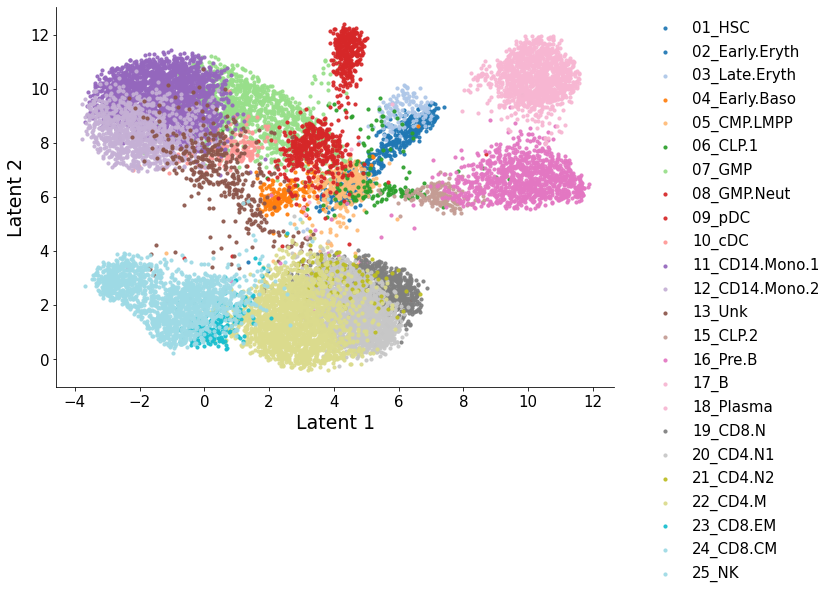

In [10]:
# Visualize the processed scATAC-Seq data
# latent semantic indexing, reduce the dimensionality
lsi_atac = utils.lsi_ATAC(R_f.T.values > 0.5, k = 30)
umap_atac = UMAP(n_components = 2, n_neighbors = 5, min_dist = 0.3).fit_transform(lsi_atac)

utils.plot_latent(z = umap_atac, anno = meta_atac["celltype"].values.squeeze(), figsize = (10,7))

None


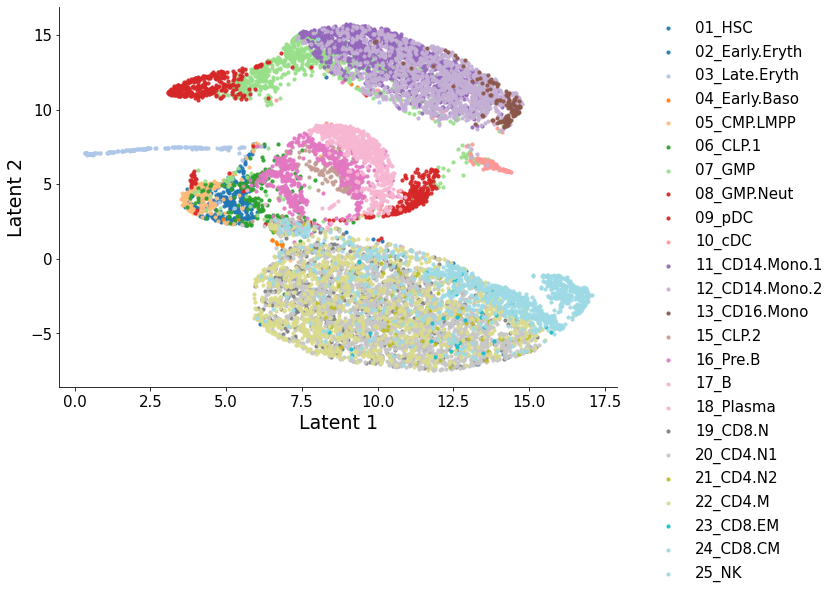

In [11]:
# visualize the processed scRNA-Seq data
pca_rna = PCA(n_components = 30).fit_transform(adata[:, adata.var.highly_variable].X.todense())
umap_rna = UMAP(n_components = 2, n_neighbors = 5, min_dist = 0.3).fit_transform(pca_rna)

utils.plot_latent(z = umap_rna, anno = meta_rna["celltype"].values.squeeze(), figsize = (10,7))